In [1]:
%pip install -r requirements.txt

You should consider upgrading via the '/Users/cody/venvs/mldrift/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

In [3]:
plt.style.use("dark_background")

In [83]:
t = pd.date_range(start="2000-01-01", end=datetime.today(), freq="H")
t

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:00:00',
               '2000-01-01 02:00:00', '2000-01-01 03:00:00',
               '2000-01-01 04:00:00', '2000-01-01 05:00:00',
               '2000-01-01 06:00:00', '2000-01-01 07:00:00',
               '2000-01-01 08:00:00', '2000-01-01 09:00:00',
               ...
               '2022-03-10 04:00:00', '2022-03-10 05:00:00',
               '2022-03-10 06:00:00', '2022-03-10 07:00:00',
               '2022-03-10 08:00:00', '2022-03-10 09:00:00',
               '2022-03-10 10:00:00', '2022-03-10 11:00:00',
               '2022-03-10 12:00:00', '2022-03-10 13:00:00'],
              dtype='datetime64[ns]', length=194510, freq='H')

In [84]:
x = pd.to_numeric(t)
x

Int64Index([ 946684800000000000,  946688400000000000,  946692000000000000,
             946695600000000000,  946699200000000000,  946702800000000000,
             946706400000000000,  946710000000000000,  946713600000000000,
             946717200000000000,
            ...
            1646884800000000000, 1646888400000000000, 1646892000000000000,
            1646895600000000000, 1646899200000000000, 1646902800000000000,
            1646906400000000000, 1646910000000000000, 1646913600000000000,
            1646917200000000000],
           dtype='int64', length=194510)

In [137]:
r = np.random.random(x.shape)
r.shape

(194510,)

In [124]:
f = 1/(365*24*60*60*30*10**9) * 10 # f ~= 1/year
f

1.0569930661254861e-17

In [129]:
y = np.sin(2*np.pi*f*x)
y

Float64Index([ 0.04015568188006707,  0.04039457409051977, 0.040633463991929325,
              0.040872351570640265, 0.041111236812997255, 0.041350119705345086,
               0.04158900023402868,   0.0418278783854002,  0.04206675414579064,
               0.04230562750155244,
              ...
                0.5492426120142324,   0.5490428008417345,   0.5488429582847367,
                0.5486430843546622,   0.5484431790629365,   0.5482432424209865,
                0.5480432744402409,   0.5478432751321306,   0.5476432445080758,
                0.5474431825795346],
             dtype='float64', length=194510)

In [176]:
data = {
    "f1": np.sin(2*np.pi*f*x),
    "f2": np.random.random() * 2 * np.cos(2*np.pi*f*x) + .2*np.random.random(x.shape),
    "f3": np.sinc(2*np.pi*f*x),
    "f4": 1+0.01*np.random.random(x.shape),
    "f5": 1+.2*np.random.random(x.shape),
}

df = pd.DataFrame(data, index=t)

In [177]:
len(data)

5

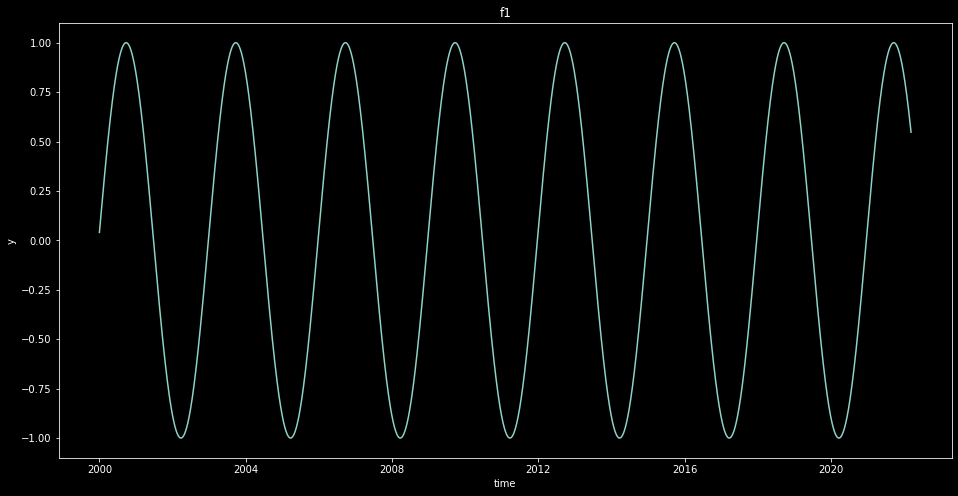

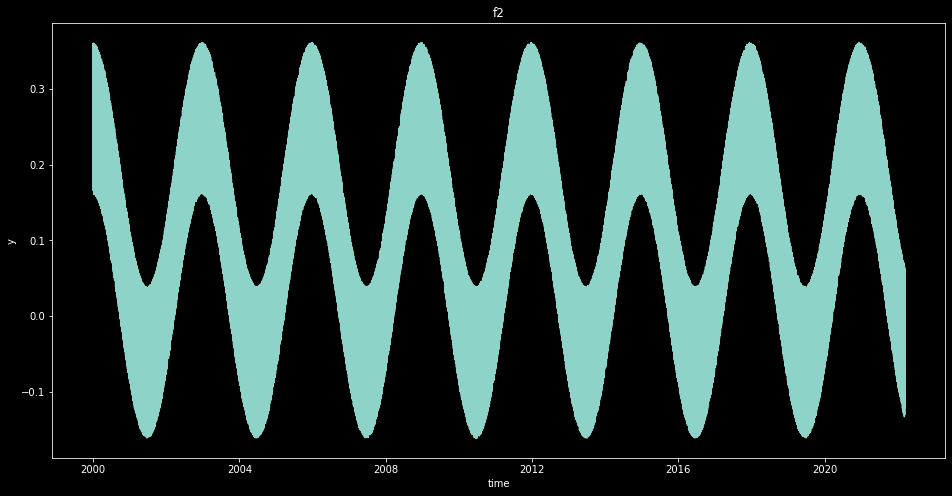

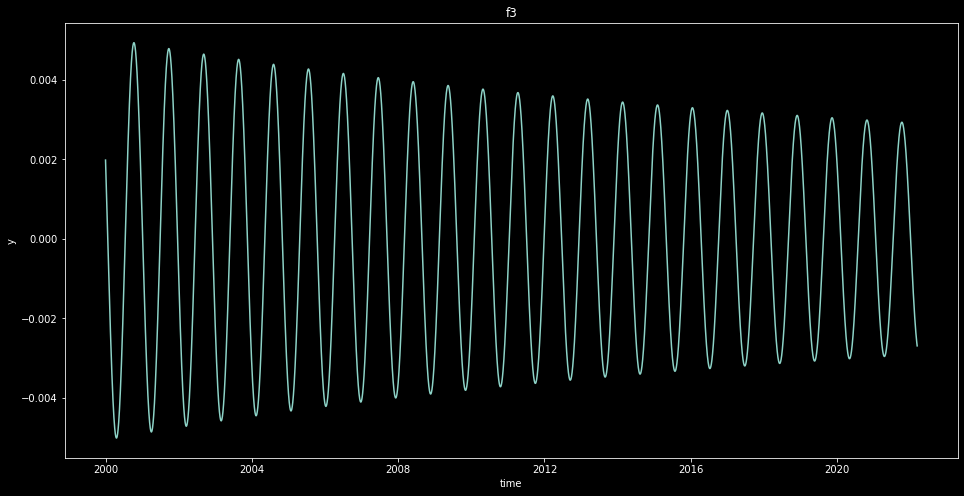

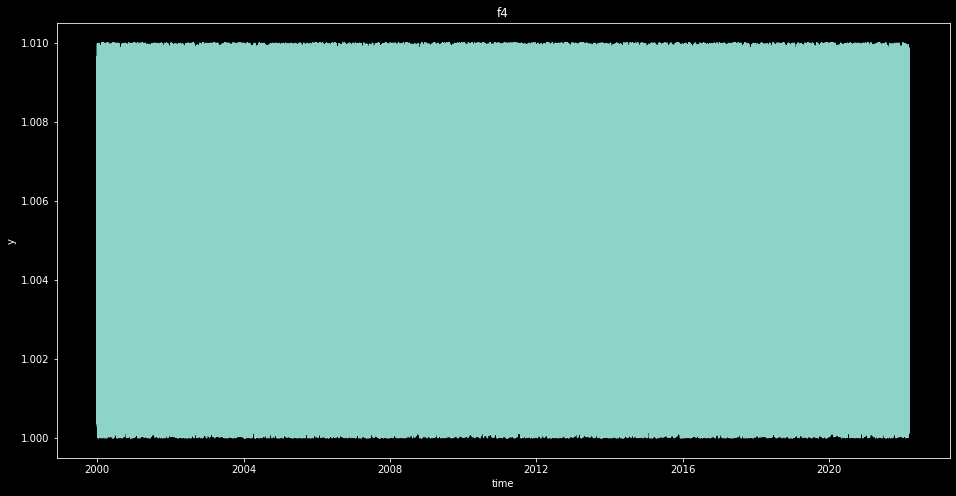

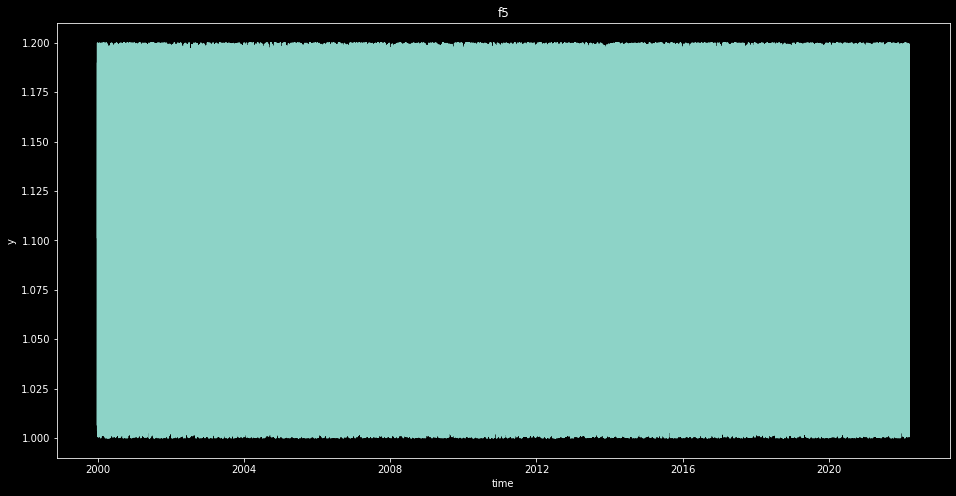

In [178]:
for i in range(len(data)):
    
    fig, ax = plt.subplots(figsize=(16, 8))

    ax.set_xlabel("time")
    ax.set_ylabel("y")
    ax.set_title(f"f{i+1}")

    plt.plot(t, df[f"f{i+1}"])

In [179]:
baseline = df.loc["2000-01-01":"2000-04-01"]
baseline

,f1,f2,f3,f4,f5
2000-01-01 00:00:00,0.040156,0.213547,0.001981,1.004094,1.101459
2000-01-01 01:00:00,0.040395,0.186930,0.001978,1.009263,1.145546
2000-01-01 02:00:00,0.040633,0.313570,0.001974,1.007257,1.172680
2000-01-01 03:00:00,0.040872,0.327665,0.001971,1.001517,1.006416
2000-01-01 04:00:00,0.041111,0.263905,0.001967,1.006519,1.139231
...,...,...,...,...,...
2000-04-01 19:00:00,0.536997,0.240982,-0.004769,1.008306,1.043622
2000-04-01 20:00:00,0.537199,0.138511,-0.004770,1.006229,1.033274
2000-04-01 21:00:00,0.537400,0.230285,-0.004771,1.000496,1.095453
2000-04-01 22:00:00,0.537602,0.252943,-0.004772,1.003452,1.070823


In [180]:
test = df.loc["2000-04-01":"2000-05-01"]
test

,f1,f2,f3,f4,f5
2000-04-01 00:00:00,0.533159,0.222173,-0.004746,1.003928,1.101909
2000-04-01 01:00:00,0.533362,0.173621,-0.004747,1.001173,1.186245
2000-04-01 02:00:00,0.533564,0.208417,-0.004749,1.000366,1.108340
2000-04-01 03:00:00,0.533766,0.322287,-0.004750,1.009984,1.009883
2000-04-01 04:00:00,0.533968,0.228421,-0.004751,1.003879,1.067965
...,...,...,...,...,...
2000-05-01 19:00:00,0.673561,0.285421,-0.004884,1.006577,1.020274
2000-05-01 20:00:00,0.673737,0.249134,-0.004883,1.008689,1.018090
2000-05-01 21:00:00,0.673914,0.303812,-0.004882,1.008150,1.152302
2000-05-01 22:00:00,0.674090,0.311318,-0.004881,1.009664,1.096523


In [181]:
from src.datadrift._datadiff import DataDiff, Distribution

In [182]:
def get_distributions(pd_dataset, decimal=3):
    distributions = []

    for column in pd_dataset:
        binlabel, weight = np.unique(np.around(pd_dataset[column].values, decimal), return_counts=True)
        distributions.append(Distribution(column, binlabel, weight))

    return distributions

In [183]:
drift = DataDiff(baseline, test, get_distributions(baseline), get_distributions(test))

In [185]:
metrics = drift.run()

In [186]:
metrics

[{"name": "datadrift_coefficient", "value": 0.9660474054972095, "schema_version": "1.0", "extended_properties": {"metric_type": "dataset", "mcc_train_for_debug": 0.9910246744984892, "mcc_test_for_debug": 0.9660474054972095, "mcc_all_for_debug": 0.9785078268723653}},
 {"name": "datadrift_contribution", "value": 585.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f1"}},
 {"name": "datadrift_contribution", "value": 387.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f2"}},
 {"name": "datadrift_contribution", "value": 114.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f3"}},
 {"name": "datadrift_contribution", "value": 475.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f4"}},
 {"name": "datadrift_contribution", "value": 383.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_nam

In [187]:
metrics[0]

{"name": "datadrift_coefficient", "value": 0.9660474054972095, "schema_version": "1.0", "extended_properties": {"metric_type": "dataset", "mcc_train_for_debug": 0.9910246744984892, "mcc_test_for_debug": 0.9660474054972095, "mcc_all_for_debug": 0.9785078268723653}}

In [188]:
metrics[1]

{"name": "datadrift_contribution", "value": 585.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f1"}}

In [189]:
metrics[2]

{"name": "datadrift_contribution", "value": 387.0, "schema_version": "1.0", "extended_properties": {"metric_type": "column", "column_name": "f2"}}

In [190]:
len(metrics)

16

In [ ]:
start = datetime("2000-04-01")

while start < datetime.now():

    test = df.loc[start, start+timedelta(days=30)]

    start += timedelta(days=30)